In [1]:
from retrieve import Basket
from retrieve import RecommendTicker
import bt

symbols = list(Basket().get_portfolio().keys())

symbols.extend(RecommendTicker().recommend_tickers())

df = bt.get(symbols,start="2020-01-01")

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ECC%20%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ECC+++++++++++&crumb=oq5XMMdoy35
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SAND%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SAND++++++++++&crumb=oq5XMMdoy35


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


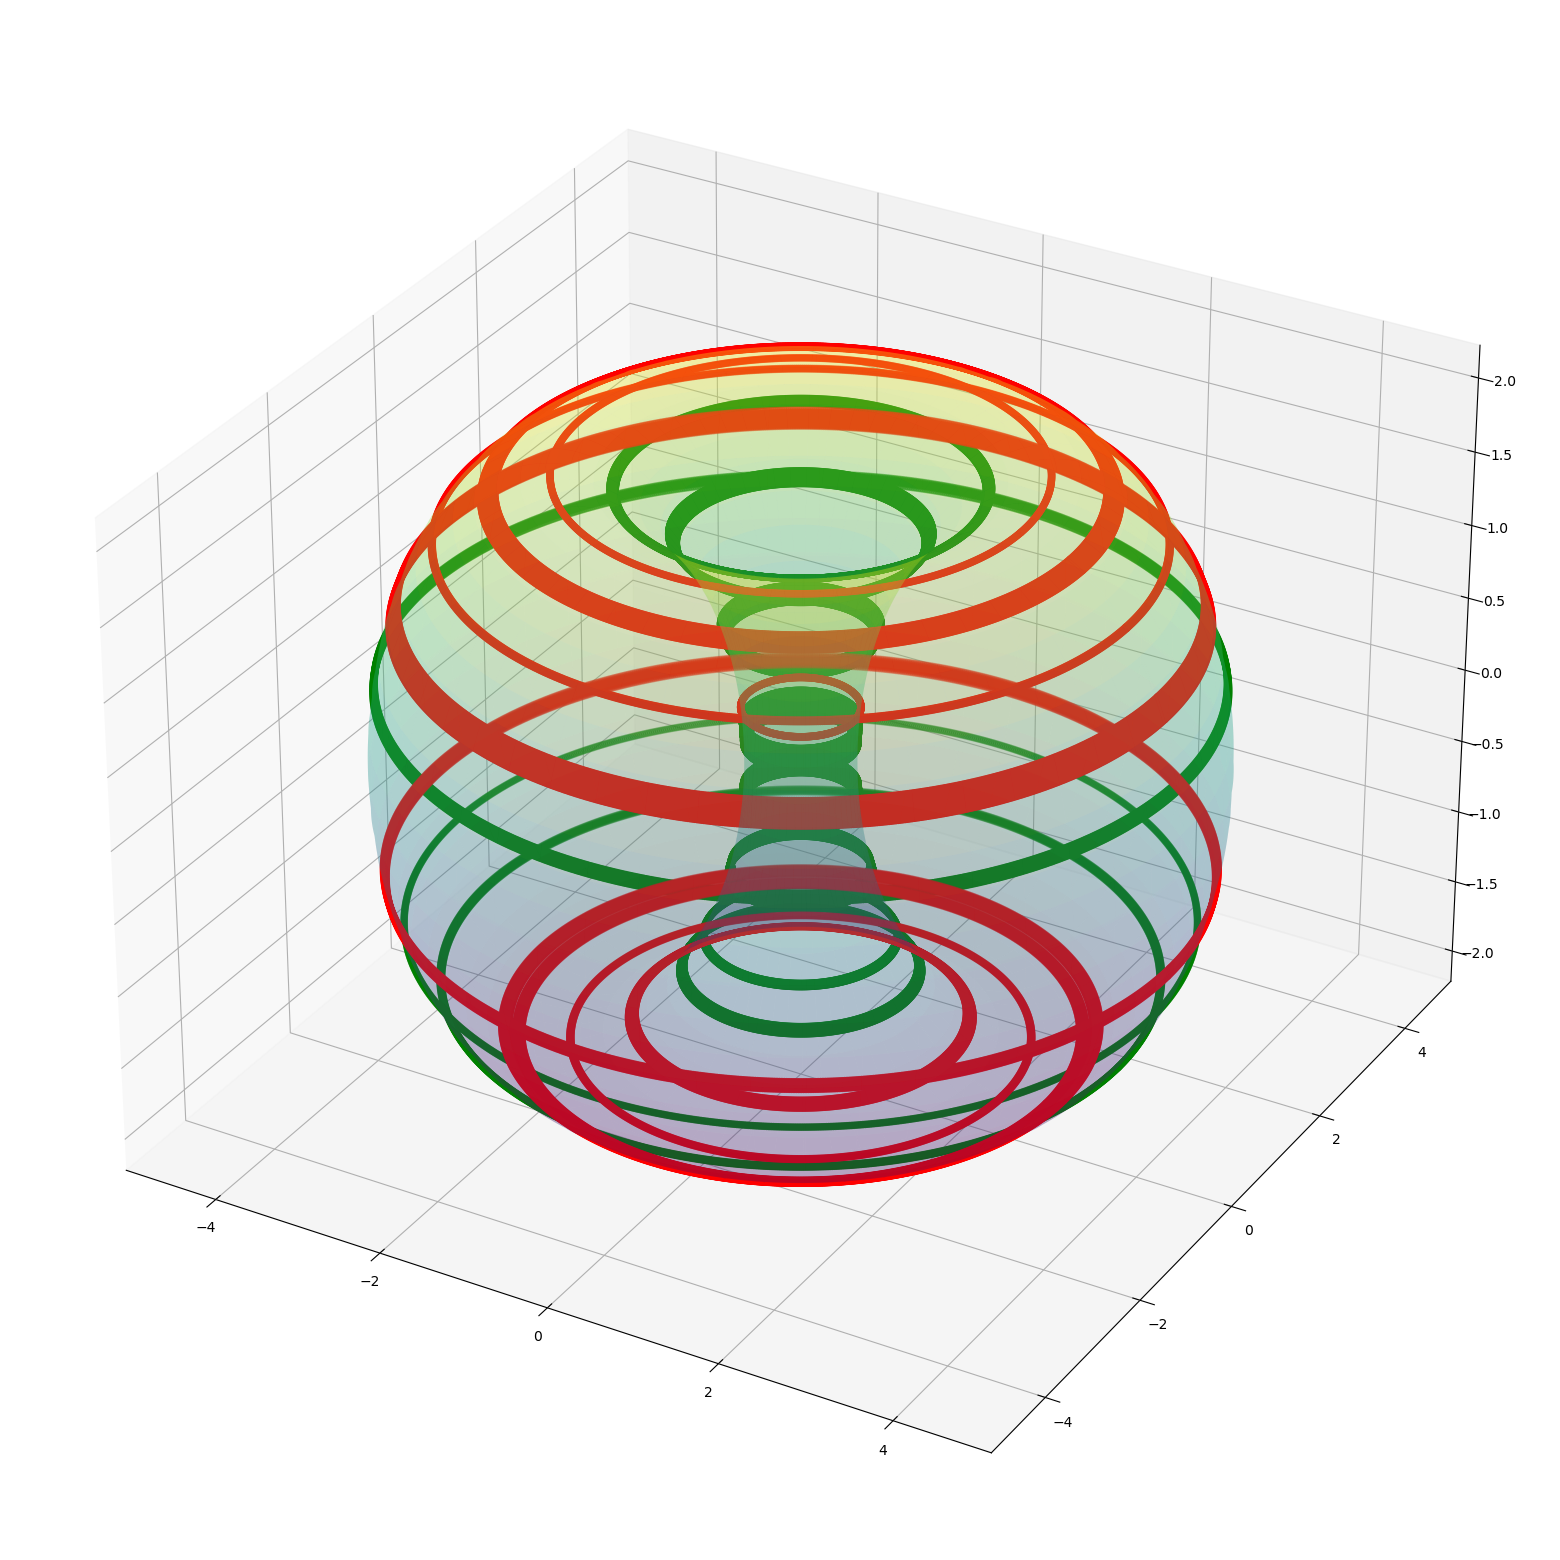

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

big = 2*np.pi

df_filter = df - df.iloc[0]

norm_price = (df_filter - df_filter.min()) / (df_filter.max() - df_filter.min()) * big

rolling_mean = norm_price.rolling(window=50).mean()
rolling_std = norm_price.rolling(window=50).std()

buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

plot_torus("cdlx",big,rolling_mean,rolling_std,buy_signal,sell_signal,len(df))

In [3]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(buy_signal.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action.iloc[51:]

,cdlxSignal,cvxSignal,pyplSignal,modSignal,calmSignal,indaSignal,anfSignal,sigaSignal
Date,,,,,,,,
2020-03-17,Hold,Buy,Buy,Buy,Sell,Buy,Buy,Hold
2020-03-18,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Buy
2020-03-19,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Hold
2020-03-20,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Hold
2020-03-23,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Hold
...,...,...,...,...,...,...,...,...
2024-06-24,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2024-06-25,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2024-06-26,Hold,Hold,Buy,Hold,Hold,Hold,Hold,Hold


sellTailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

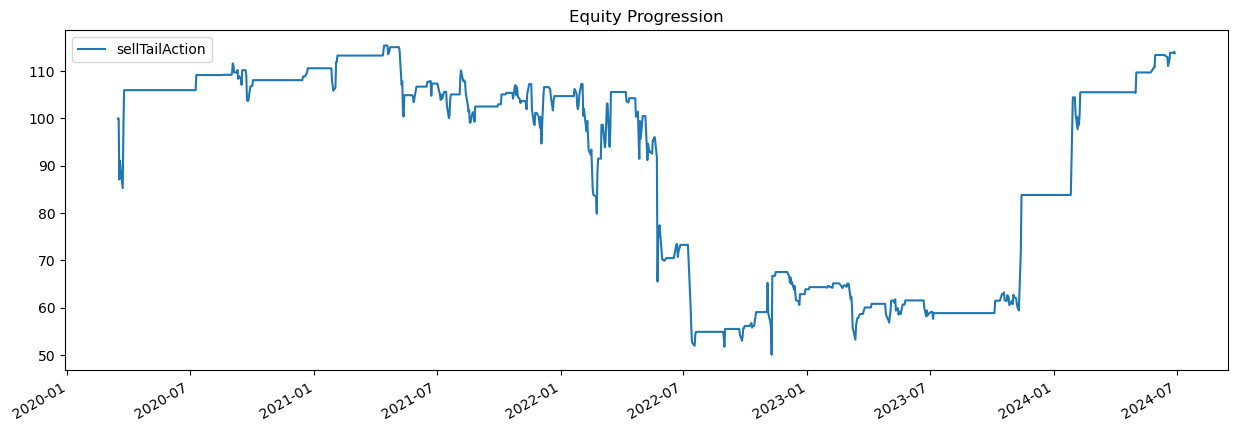

In [4]:
strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

res = bt.run(t2)
res.plot()

<Axes: title={'center': 'Equity Progression'}>

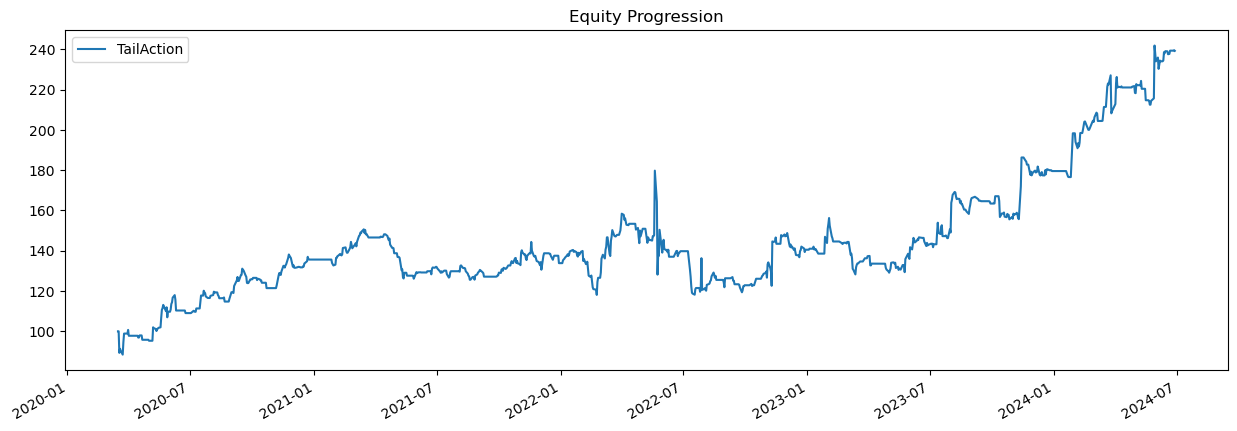

In [5]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1, df.iloc[51:,:],integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df.iloc[51:,:],
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [6]:
res.stats

,TailAction
start,2020-03-16 00:00:00
end,2024-06-28 00:00:00
rf,0.0
total_return,1.3922
cagr,0.225762
max_drawdown,-0.34252
calmar,0.659121
mtd,0.022299
three_month,0.139148
six_month,0.329263


In [7]:
# import json
# import requests
# import os
# import yfinance as yf

# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# tickers = list(criteria["Portfolio Weights"].keys())

# for stock_ex in criteria["Exchanges"]:
#     github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
#     exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

#     url = github_branch + exchange # combining the repository dataset with the specific exchange

#     resp = requests.get(url)
#     data = json.loads(resp.text)

#     for i in range(len(data)):
#         ticker = data[i]

#         immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
#         # important to note that since the list of tickers is massive, need to find any method to narrow scope

#         # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
#         if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
#             continue

#         # numeric comparison
#         lastsale = float(ticker[immediate_criteria[0]][1:])
#         volume = float(ticker[immediate_criteria[1]])
#         marketCap = float(ticker[immediate_criteria[2]])

#         # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
#         check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
#             and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
#         check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

#         if check_1 and check_2:
#             greater = criteria["Portfolio Criteria"]["Greater"]
#             less_than = criteria["Portfolio Criteria"]["Less Than"]

#             symbol = ticker["symbol"]

#             # list of metrics for criteria
#             metrics = list(greater.keys())
#             metrics.extend(list(less_than.keys()))

#             values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
#             try:
#                 # Step 3: select tickers whick satisfy all of these conditions
#                 check_3 = all(values[metric] > x for metric,x in greater.items()) 
#                 check_4 = all(values[metric] < x for metric,x in less_than.items())
#                 if check_3 and check_4:
#                     tickers.append(symbol)

#             except KeyError:
#                 continue

# print(tickers)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

ticker = "PFE"

a = yf.Ticker(ticker).income_stmt
b = yf.Ticker(ticker).cash_flow
c = yf.Ticker(ticker).balance_sheet

inital = ["Total Revenue", "EBIT", "Tax Provision", "Depreciation And Amortization", "Capital Expenditure", 
          "Change In Working Capital", "Cash And Cash Equivalents", "Total Debt", "Ordinary Shares Number"]

f = pd.concat([a,b,c],axis=0)
f = f.loc[f.index.isin(inital)]

f.columns = [int(val.strftime("%Y")) for val in f.columns.tolist()]
start = max(f.columns.tolist())

f = f.dropna(axis=1).T

for col in inital:
    f[col] = f[col]/1000000

f = f[inital]

if f.index.values.tolist()[0] == start:
    f = f.iloc[::-1]

cash = f.loc[f.index == start,inital[-3]].values.tolist()[0]
debt = f.loc[f.index == start,inital[-2]].values.tolist()[0]
shares = f.loc[f.index == start,inital[-1]].values.tolist()[0]

f = f.drop(inital[6:],axis=1)

g = pd.DataFrame()

g.index = f.index.values-start

g["Total Revenue"] = (f["Total Revenue"]/f["Total Revenue"].shift(1)).values-1
g["EBIT"] = (f["EBIT"]/f["Total Revenue"]).values

for a in inital[2:6]:
    g[a] = (f[a]/f["EBIT"]).values

g = g.T
f = f.T

for i,k in zip(range(0,5,1), range(start,start+5,1)):
    v = [j for j in range(g.columns.tolist()[i],i+1,1)]
    g[i+1] = g[v].mean(axis=1)
    f[k+1] = f[k] * (1+g[i+1])

cols1 = f.columns.tolist()
cols1 = np.array(cols1[cols1.index(start+1):])

f = f[cols1]

v = f.T

unlevered_fcf = v["EBIT"]-v["Tax Provision"]+v["Depreciation And Amortization"]-v["Change In Working Capital"]-v["Capital Expenditure"]

cols2 = g.columns.tolist()
cols2 = np.array(cols2[cols2.index(1):])

pv_fcf = unlevered_fcf.values/((1+.15)**cols2)

tv = (unlevered_fcf.values.tolist()[-1]*(1+.15))/(.15-.03)

pv_tv = tv/((1+.15)**cols2.flatten().tolist()[-1])

enterprise_value = pv_tv + pv_fcf.sum()

fair_value = (enterprise_value+cash-debt)/shares

fair_value

143.28739752396376

In [27]:
a

,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.33,0.34,0.028,0.112
Net Income From Continuing Operation Net Minority Interest,1030530000.0,-364578000.0,-164993000.0,-171491000.0
Reconciled Depreciation,62895000.0,35581000.0,17339000.0,7428000.0
Net Interest Income,4402787000.0,2007310000.0,679402000.0,167846000.0
Interest Expense,2036925000.0,1547903000.0,367344000.0,215076000.0
Interest Income,6439712000.0,3555213000.0,1046746000.0,382922000.0
Normalized Income,1030530000.0,-364578000.0,-164993000.0,-171491000.0
Net Income From Continuing And Discontinued Operation,1030530000.0,-364578000.0,-164993000.0,-171491000.0
Diluted Average Shares,4857579000.0,4676977000.0,4609988546.0,4608684459.0


In [28]:
b.head(n=60)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Free Cash Flow,1089186000.0,641267000.0,-2952816000.0,966534000.0,NaN
Repurchase Of Capital Stock,0.0,0.0,-4607000.0,-15000.0,NaN
Repayment Of Debt,-53434000.0,-175621000.0,-131313000.0,-84633000.0,NaN
Issuance Of Debt,469501000.0,581142000.0,116349000.0,17974000.0,NaN
Issuance Of Capital Stock,0.0,247998000.0,3390846000.0,300000000.0,NaN
Capital Expenditure,-177003000.0,-114306000.0,-28498000.0,-7986000.0,NaN
End Cash Position,5923440000.0,4172316000.0,2705675000.0,2343780000.0,NaN
Beginning Cash Position,4172316000.0,2705675000.0,2343780000.0,1246566000.0,NaN
Effect Of Exchange Rate Changes,236723000.0,184181000.0,104426000.0,-101138000.0,NaN
Changes In Cash,1514401000.0,1282460000.0,257469000.0,1198352000.0,NaN


In [29]:
b.tail(n=3)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Operating Gains Losses,20000.0,848000.0,-39280000.0,48433000.0,NaN
Gain Loss On Investment Securities,NaN,18642000.0,-19942000.0,48433000.0,1799000.0
Net Income From Continuing Operations,1030530000.0,-364634000.0,-165334000.0,-171491000.0,NaN


In [30]:
c.head(n=60)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Treasury Shares Number,0.0,NaN,NaN,NaN,NaN
Ordinary Shares Number,4765937154.0,4694787854.0,4609988546.0,4608684459.0,NaN
Share Issued,4765937154.0,4694787854.0,4609988546.0,4608684459.0,NaN
Total Debt,1173286000.0,605921000.0,164875000.0,189210000.0,NaN
Tangible Book Value,5712966000.0,4311222000.0,3966823000.0,424908000.0,NaN
Invested Capital,7542729000.0,5476351000.0,4598286000.0,615307000.0,NaN
Net Tangible Assets,5712966000.0,4311222000.0,3966823000.0,424908000.0,NaN
Capital Lease Obligations,36942000.0,20353000.0,7621000.0,12014000.0,NaN
Common Stock Equity,6406385000.0,4890783000.0,4441032000.0,438111000.0,NaN
Total Capitalization,7429134000.0,5438022000.0,4598286000.0,615307000.0,NaN


In [31]:
c.tail(n=11)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Other Properties,69753000.0,46464000.0,20535000.0,20510000.0,NaN
Prepaid Assets,178082000.0,84406000.0,39916000.0,18493000.0,NaN
Receivables,14531873000.0,9000760000.0,4902734000.0,2940609000.0,NaN
Other Receivables,2117772000.0,767637000.0,122214000.0,31702000.0,NaN
Accounts Receivable,12414101000.0,8233123000.0,4780520000.0,2908907000.0,NaN
Allowance For Doubtful Accounts Receivable,-2074203000.0,-1033102000.0,-381633000.0,-209965000.0,NaN
Gross Accounts Receivable,14488304000.0,9266225000.0,5162153000.0,3118872000.0,NaN
Other Short Term Investments,8805745000.0,9947138000.0,8163428000.0,0.0,NaN
Cash And Cash Equivalents,13422632000.0,6890816000.0,2528529000.0,603334000.0,NaN
Cash Equivalents,856321000.0,154920000.0,1415728000.0,416858000.0,NaN


In [32]:
yf.Ticker("NU").info

{'address1': 'Rua Capote Valente, 39',
 'city': 'São Paulo',
 'state': 'SP',
 'zip': '05409-000',
 'country': 'Brazil',
 'website': 'https://www.nubank.com.br',
 'industry': 'Banks - Regional',
 'industryKey': 'banks-regional',
 'industryDisp': 'Banks - Regional',
 'sector': 'Financial Services',
 'sectorKey': 'financial-services',
 'sectorDisp': 'Financial Services',
 'longBusinessSummary': 'Nu Holdings Ltd. provides digital banking platform in Brazil, Mexico, Colombia, Cayman Islands, Germany, Argentina, the United States, and Uruguay. It offers spending solutions comprising Nu credit and prepaid card, a digitally enabled card that acts as a credit and a prepaid card; Ultraviolet credit and prepaid card, a premium metal credit card for affluent customers; mobile payment solutions for NuAccount customers to make and receive transfers, pay bills, and make everyday purchases through their mobile phones; and Nu Shopping, an integrated mall that enables customers to purchase goods and ser

In [2]:
import yfinance as yf
import pandas as pd

# Define the tickers for the comparable companies and the target company
comps_tickers = ['AAPL', 'MSFT', 'GOOGL']  # Example comparable companies
target_ticker = 'GDDY'  # Example target company

# Retrieve financial data for the comparable companies
def get_financial_data(tickers):
    financials = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        # Get the necessary financial data
        market_cap = stock.info['marketCap']
        revenue = stock.financials.loc['Total Revenue'][0]
        ebitda = stock.financials.loc['EBITDA'][0]
        financials.append({
            'Ticker': ticker,
            'Market Cap': market_cap,
            'Revenue': revenue,
            'EBITDA': ebitda
        })
    return pd.DataFrame(financials)

# Get financial data for comparable companies
comps_data = get_financial_data(comps_tickers)

# Calculate key financial ratios for comparable companies
comps_data['EV/Revenue'] = comps_data['Market Cap'] / comps_data['Revenue']
comps_data['EV/EBITDA'] = comps_data['Market Cap'] / comps_data['EBITDA']

# Retrieve financial data for the target company
target_data = get_financial_data([target_ticker])

# Display the data
print("Comparable Companies Data:")
print(comps_data)

print("\nTarget Company Data:")
print(target_data)

# Calculate the target company's implied valuation based on comps' multiples
ev_to_revenue_avg = comps_data['EV/Revenue'].mean()
ev_to_ebitda_avg = comps_data['EV/EBITDA'].mean()

target_revenue = target_data['Revenue'].values[0]
target_ebitda = target_data['EBITDA'].values[0]

implied_ev_revenue = target_revenue * ev_to_revenue_avg
implied_ev_ebitda = target_ebitda * ev_to_ebitda_avg

print(f"\nImplied Enterprise Value based on EV/Revenue multiple: ${implied_ev_revenue:,.2f}")
print(f"Implied Enterprise Value based on EV/EBITDA multiple: ${implied_ev_ebitda:,.2f}")


Comparable Companies Data:
  Ticker     Market Cap       Revenue        EBITDA  EV/Revenue  EV/EBITDA
0   AAPL  3572538540032  3.832850e+11  1.291880e+11    9.320841  27.653796
1   MSFT  3465314304000  2.119150e+11  1.051400e+11   16.352379  32.959048
2  GOOGL  2343618215936  3.073940e+11  9.797100e+10    7.624151  23.921550

Target Company Data:
  Ticker   Market Cap       Revenue       EBITDA
0   GDDY  20348987392  4.254100e+09  754100000.0

Implied Enterprise Value based on EV/Revenue multiple: $47,216,781,105.46
Implied Enterprise Value based on EV/EBITDA multiple: $21,249,128,824.76


In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import pairwise_distances_argmin_min

# Define the tickers and industries
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'BABA', 'JPM']
industries = ['Technology', 'Technology', 'Technology', 'Consumer Discretionary', 
              'Communication Services', 'Consumer Discretionary', 'Communication Services', 
              'Technology', 'Consumer Discretionary', 'Financials']

# Retrieve stock price data
def get_stock_price(tickers):
    prices = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        price = stock.history(period="1d")['Close'][0]
        prices.append(price)
    return prices

# Get stock prices
prices = get_stock_price(tickers)

# Create a DataFrame
data = pd.DataFrame({
    'Ticker': tickers,
    'Industry': industries,
    'Price': prices
})

# Preprocess the data
encoder = OneHotEncoder()
industry_encoded = encoder.fit_transform(data[['Industry']]).toarray()
price_scaled = StandardScaler().fit_transform(data[['Price']])

# Combine the encoded industry and scaled price
features = pd.DataFrame(industry_encoded).join(pd.DataFrame(price_scaled))

# Perform K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
data['Cluster'] = kmeans.fit_predict(features)

# Function to find the closest tickers
def find_closest_tickers(ticker, data, features, k=5):
    ticker_index = data[data['Ticker'] == ticker].index[0]
    cluster = data.loc[ticker_index, 'Cluster']
    cluster_data = data[data['Cluster'] == cluster]
    cluster_features = features.iloc[cluster_data.index]
    
    closest_indices, _ = pairwise_distances_argmin_min([features.iloc[ticker_index]], cluster_features)
    
    # Exclude the input ticker and get the closest k tickers
    closest_tickers = cluster_data.iloc[closest_indices].loc[cluster_data.index != ticker_index]['Ticker'].head(k).values
    return closest_tickers

# Example usage
target_ticker = 'AAPL'
closest_tickers = find_closest_tickers(target_ticker, data, features)
print(f"The five closest tickers to {target_ticker} are: {closest_tickers}")


In [ ]:
def find_closest_tickers(ticker, data, k=5):
    ticker_index = data[data['Ticker'] == ticker].index[0]
    cluster = data.loc[ticker_index, 'Cluster']
    cluster_data = data[data['Cluster'] == cluster]
    cluster_features = features.loc[cluster_data.index]

    closest_indices, _ = pairwise_distances_argmin_min([features.loc[ticker_index]], cluster_features)
    closest_tickers = cluster_data.iloc[closest_indices[1:k+1]]['Ticker'].values
    return cluster_features

find_closest_tickers("AAPL", data)

In [ ]:
import json
import os
import requests
import yfinance as yf
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"

tickers = {}

for stock_ex in criteria["Exchanges"]:
    exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json"
    resp = requests.get(github_branch + exchange)
    tickers[stock_ex] = json.loads(resp.text)

print(tickers["amex"][0])